In [1]:
!pip install matplotlib
!pip install matplotlib-inline
!pip install seaborn
!pip install boto3


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


# Importar librerías necesarias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import joblib
import boto3, os

# these are the env variable injected by Red Hat Data Science based on your Data Connection settings. 
# env variables injected
# AWS_S3_ENDPOINT=http://minio-ml-workshop.ml-workshop.svc.cluster.local
# AWS_DEFAULT_REGION=us-east-1
# AWS_SECRET_ACCESS_KEY=minio123
# AWS_S3_BUCKET=demo-project
# AWS_ACCESS_KEY_ID=minio
 
BUCKET = os.getenv("AWS_S3_BUCKET")
HTTP = 'http://'
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
REGIONNAME = os.getenv("AWS_DEFAULT_REGION")
AWS_S3_ENDPOINT = os.getenv("AWS_S3_ENDPOINT")



# Lectura del archivo y perfilamiento de los datos

Se procede a leer el archivo mall_customer.csv. Posteriormente, se procede a realizar una labor de perfilamiento y descripción del conjunto de datos con el fin de identificar datos anomalos, distribuciones, datos estadisticos y tipos de datos de las variables.

In [4]:
s3 = boto3.resource('s3',endpoint_url = AWS_S3_ENDPOINT +":9000",aws_access_key_id=AWS_ACCESS_KEY_ID,aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
s3.Bucket('model-data').download_file('mall_customer.csv','./data/mall_customer.csv')
data_original = pd.read_csv('./data/mall_customer.csv',sep=',', encoding='utf-8',index_col=0)
data_original.shape


(350, 4)

In [5]:

data_original.head()


,Gender,Age,Annual_Income,Spending_Score_(1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


<AxesSubplot: xlabel='Annual_Income', ylabel='Spending_Score_(1-100)'>

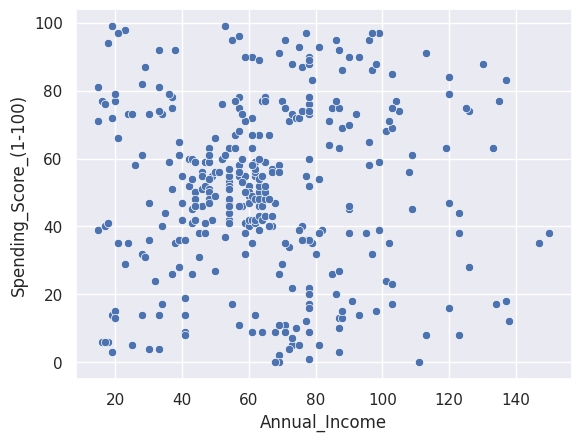

In [6]:
sns.scatterplot(data = data_original, x = 'Annual_Income', y = 'Spending_Score_(1-100)')

In [7]:
data_original.describe()

,Age,Annual_Income,Spending_Score_(1-100)
count,350.000000,350.000000,350.000000
mean,43.391429,64.460000,50.451429
std,16.072666,27.488833,25.308111
min,18.000000,15.000000,0.000000
25%,30.000000,46.000000,35.000000
50%,46.000000,62.000000,51.000000
75%,49.000000,78.000000,71.000000
max,85.000000,150.000000,99.000000


In [8]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 1 to 300
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  350 non-null    object
 1   Age                     350 non-null    int64 
 2   Annual_Income           350 non-null    int64 
 3   Spending_Score_(1-100)  350 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 13.7+ KB


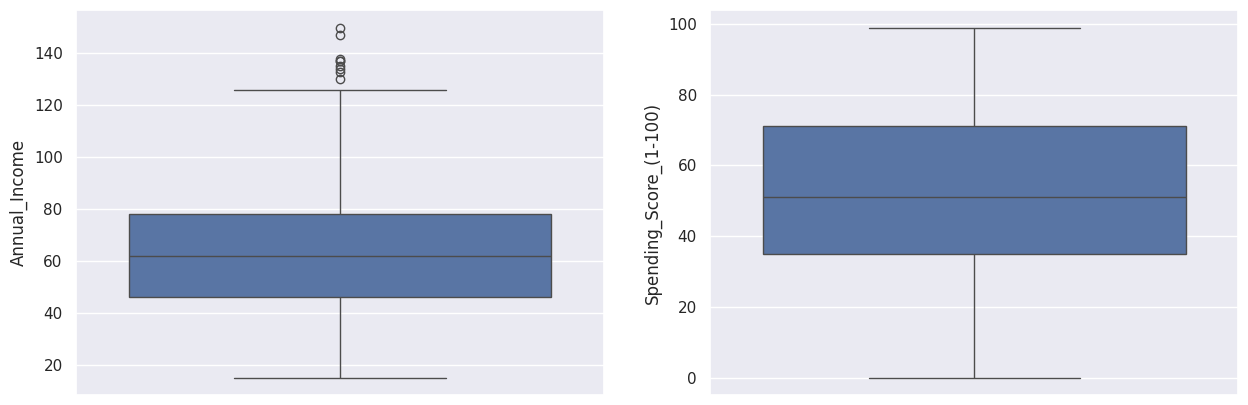

In [9]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot(data=data_original, y="Annual_Income")

plt.subplot(1,2,2)
sns.boxplot(data=data_original, y="Spending_Score_(1-100)")

plt.show()

/tmp/ipykernel_2719/2636417182.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_original.Age)


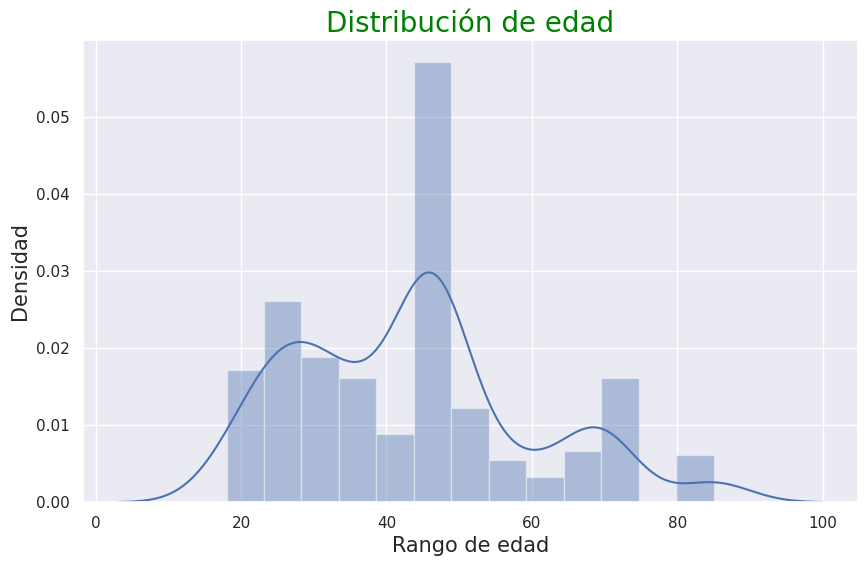

In [10]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.distplot(data_original.Age)
plt.title("Distribución de edad", fontsize=20, color="green")
plt.xlabel("Rango de edad", fontsize=15)
plt.ylabel("Densidad", fontsize=15)

plt.show()

/tmp/ipykernel_2719/3647268687.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_original["Annual_Income"])


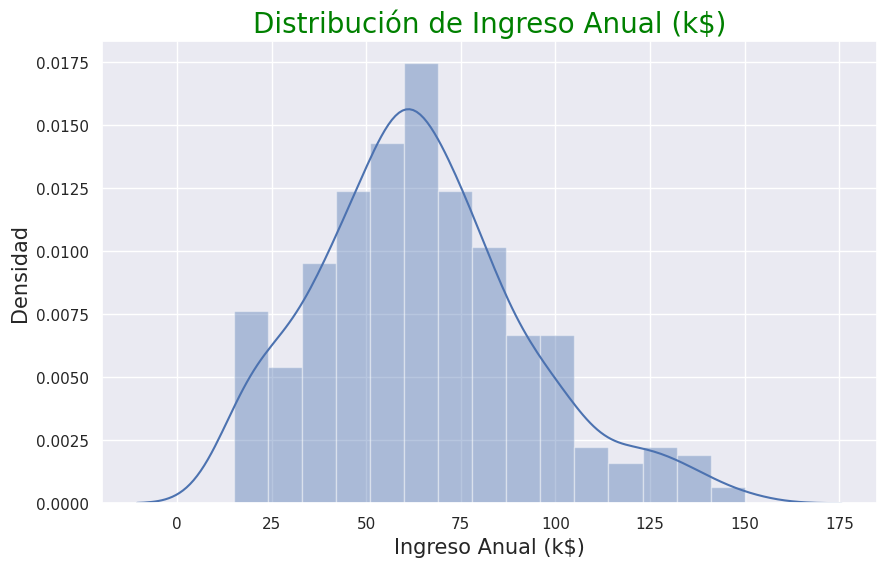

In [11]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.distplot(data_original["Annual_Income"])
plt.title("Distribución de Ingreso Anual (k$)", fontsize=20, color="green")
plt.xlabel("Ingreso Anual (k$)", fontsize=15)
plt.ylabel("Densidad", fontsize=15)
plt.show()

/tmp/ipykernel_2719/3504984805.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_original["Spending_Score_(1-100)"])


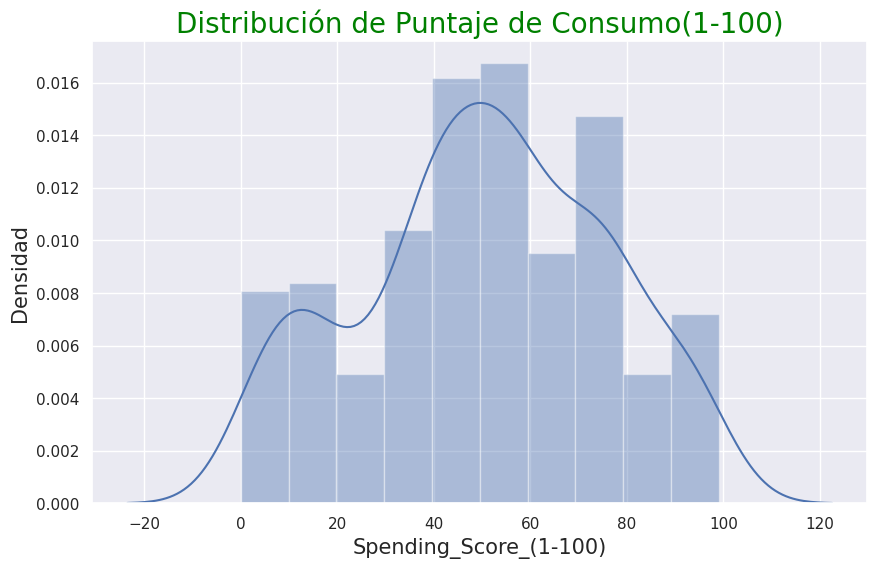

In [12]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.distplot(data_original["Spending_Score_(1-100)"])
plt.title("Distribución de Puntaje de Consumo(1-100)", fontsize=20, color="green")
plt.xlabel("Spending_Score_(1-100)", fontsize=15)
plt.ylabel("Densidad", fontsize=15)
plt.show()

# Acciones de perfilamiento

Dependiendo del conjunto de datos se pueden realizar distintos procesos de perfilamiento. Estos procesos se encargan de tratar datos anomalos (Nulos, Incorrectos) o irrelevantes para evitar un sezgo o una afectación en el modelo. Por ejemplo:


*   Los datos nulos pueden eliminarse o reemplazarse por la media/moda del conjunto de datos.
*   Datos anomalos o irreales pueden eliminarse del conjunto de datos.
*   Columnas innecesarias para el caso de uso pueden eliminarse del conjunto de datos.
*   Datos numericos pueden estandarizarse o normalizarse dependiendo del rango del rango o modelo implementado.
*   Datos categoricos pueden transformarse en datos numericos.
*   Pueden Generarse nuevos campos a partir de los campos existentes.

Todas estas operaciones de perfilamiento dependen del conjunto de datos utilizado y del modelo a implementar. Hay modelos que no permiten el uso de datos categoricos, hay modelos sensibles a datos anomalos generando un sezgo.



    

In [13]:
processed_data = data_original.drop(["Age","Gender"],axis=1)
processed_data.head()

,Annual_Income,Spending_Score_(1-100)
CustomerID,,
1,15,39
2,15,81
3,16,6
4,16,77
5,17,40


# Normalizar datos

Este proceso se encarga de transformar las columnas en un mismo rango numerico.

In [14]:
processed_data = processed_data.iloc[:,[0,1]].values
normalized_data=preprocessing.normalize(processed_data)
normalized_dataframe=pd.DataFrame(data=normalized_data[1:,1:],index=normalized_data[1:,0],columns=normalized_data[0,1:])
print(normalized_data)

[[0.35897908 0.93334561]
 [0.18208926 0.983282  ]
 [0.93632918 0.35112344]
 [0.20344646 0.97908607]
 [0.39114064 0.92033092]
 [0.21828984 0.97588398]
 [0.9486833  0.31622777]
 [0.18807227 0.98215519]
 [0.98776297 0.15596257]
 [0.25515426 0.96690036]
 [0.80505584 0.59319904]
 [0.18847945 0.98207713]
 [0.8        0.6       ]
 [0.25139836 0.9678837 ]
 [0.83844362 0.54498835]
 [0.24542187 0.96941637]
 [0.51449576 0.85749293]
 [0.30320366 0.95292578]
 [0.62139471 0.78349768]
 [0.22848559 0.97354729]
 [0.56552836 0.82472885]
 [0.31232107 0.9499766 ]
 [0.98058068 0.19611614]
 [0.32399297 0.94605949]
 [0.89442719 0.4472136 ]
 [0.32314385 0.94634986]
 [0.65850461 0.75257669]
 [0.41716766 0.90882955]
 [0.68315713 0.73027141]
 [0.31622777 0.9486833 ]
 [0.9912279  0.13216372]
 [0.38011245 0.92494028]
 [0.99273378 0.12033137]
 [0.33763235 0.94127807]
 [0.92058178 0.39054985]
 [0.37729689 0.92609236]
 [0.89442719 0.4472136 ]
 [0.42220554 0.90650013]
 [0.8181917  0.57494552]
 [0.44242424 0.89680588]


# Tuneo de Hiperparametros

Cada modelo requiere N cantidad de hiperparametros los cuales son variables de configuración de los modelos. Estos hiperparametros son configurados antes de el entrenamiento del modelo por lo que no se puede saber a priori la mejor combinación de hiperparametros que optimize el resultado del modelo. El tuneo de hiperparametros consiste en experimentos de prueba para encontrar la mejor combinación de hiperparametros basado en un indicador. Basicamente se entrena el modelo secuencialmente con distintas combinaciones hasta encontrar la combinación que arroje el mejor resultado con el conjunto de datos

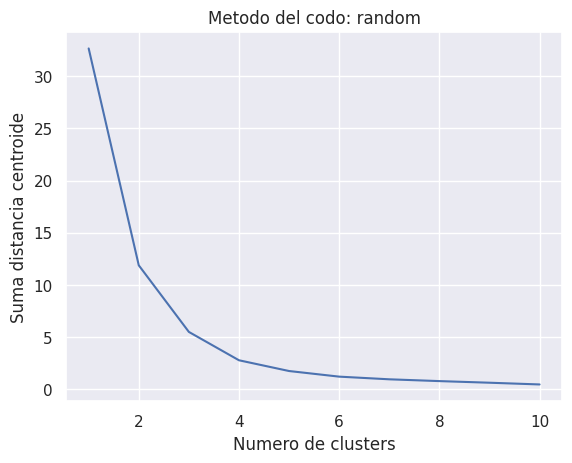

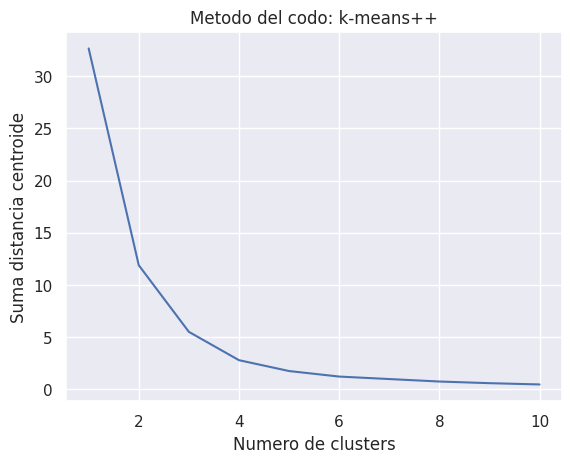

In [15]:
init = ['random','k-means++']
for j in init:
  points = []
  for k in range(1,11):
    kmeans = KMeans(k, random_state = 0, init=j, n_init = 10, max_iter = 300 ).fit(normalized_data)
    points.append(kmeans.inertia_)
  plt.plot(range(1,11),points)
  plt.title('Metodo del codo: '+j)
  plt.xlabel('Numero de clusters')
  plt.ylabel('Suma distancia centroide')
  plt.show()




# Implementación Modelo

A partir de la grafica anterior se determina que la mejor configuración de clusters es de 5, independiente del hiperparametro init. Esto al utilizar el metodo del codo el cual me indica el numero adecuado de clusters a elegir según el modelo de KMeans. Se implementa el modelo con la información y se grafican los resultados correspondientes.

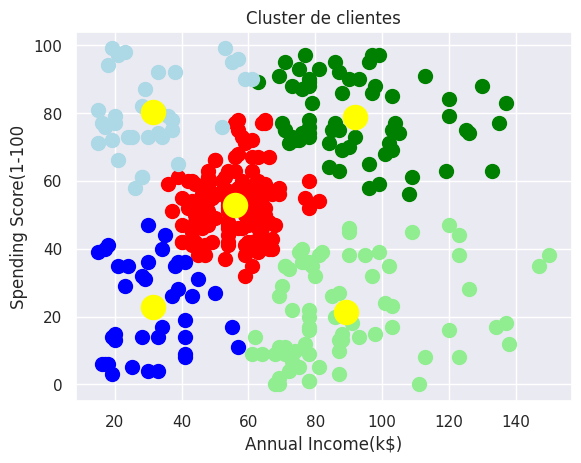

In [16]:
kmeans = KMeans(5, random_state = 0, init='random', n_init = 10, max_iter = 300 )
kmeans.fit(processed_data)
y_kmeans=kmeans.predict(processed_data)

plt.scatter(processed_data[y_kmeans==0, 0], processed_data[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(processed_data[y_kmeans==1, 0], processed_data[y_kmeans==1, 1], s=100, c='lightgreen', label ='Cluster 2')
plt.scatter(processed_data[y_kmeans==2, 0], processed_data[y_kmeans==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(processed_data[y_kmeans==3, 0], processed_data[y_kmeans==3, 1], s=100, c='lightblue', label ='Cluster 4')
plt.scatter(processed_data[y_kmeans==4, 0], processed_data[y_kmeans==4, 1], s=100, c='blue', label ='Cluster 5')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Cluster de clientes')
plt.xlabel('Annual Income(k$)')
plt.ylabel('Spending Score(1-100')
plt.show()

In [17]:
kmeans.labels_
data_original.head()

,Gender,Age,Annual_Income,Spending_Score_(1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


/tmp/ipykernel_2719/3228530818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='Annual_Income', data=data_original, palette="nipy_spectral_r")


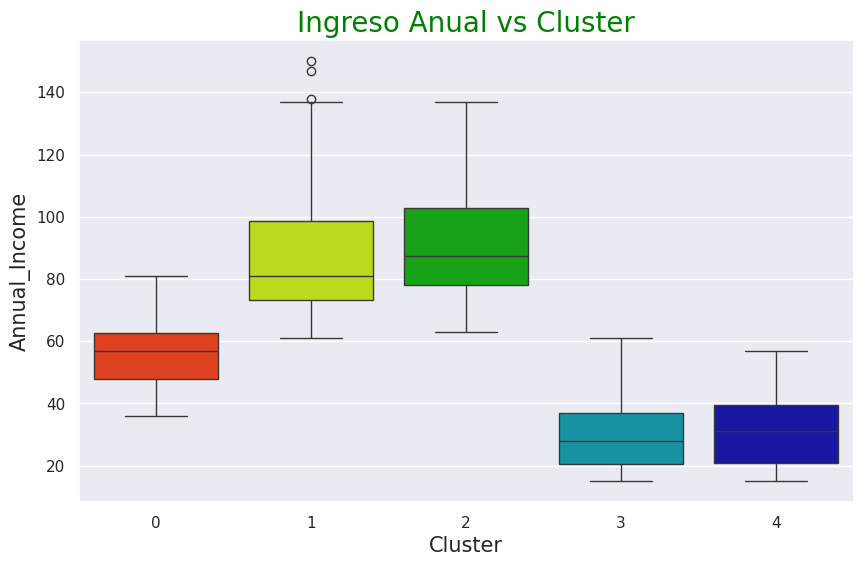

/tmp/ipykernel_2719/3228530818.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='Spending_Score_(1-100)', data=data_original, palette="nipy_spectral_r")


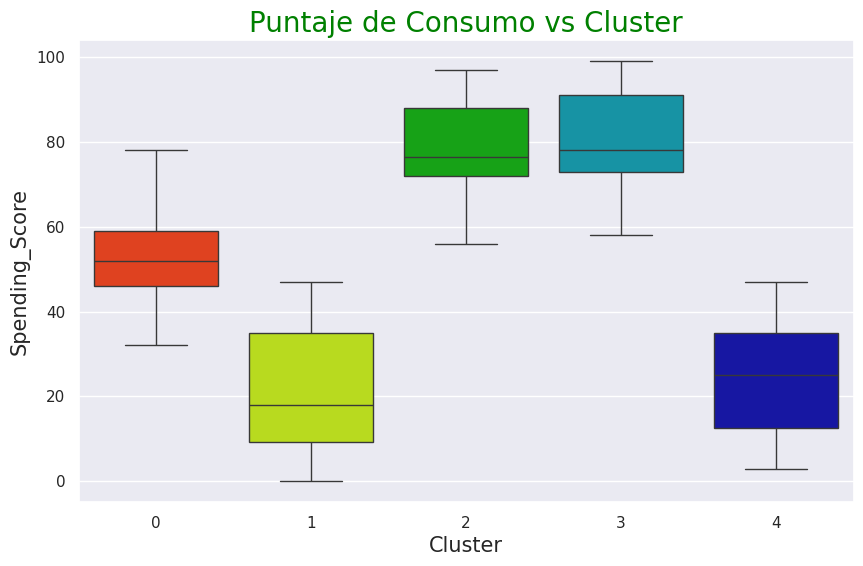

In [18]:
data_original["Label"] = kmeans.labels_
plt.figure(figsize=(10,6))
sns.boxplot(x='Label', y='Annual_Income', data=data_original, palette="nipy_spectral_r")
plt.title("Ingreso Anual vs Cluster", fontsize=20, color="green")
plt.xlabel(xlabel="Cluster", fontsize=15)
plt.ylabel(ylabel="Annual_Income",fontsize=15)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Label', y='Spending_Score_(1-100)', data=data_original, palette="nipy_spectral_r")
plt.title("Puntaje de Consumo vs Cluster", fontsize=20, color="green")
plt.xlabel(xlabel="Cluster", fontsize=15)
plt.ylabel(ylabel="Spending_Score",fontsize=15)
plt.show()

## Exportar modelo ##
Se procede a exportar el modelo para su posterior uso en aplicaciones, procesos o pipelines.

In [19]:
joblib.dump(kmeans, './model/kmeansModel.pkl')
s3 = boto3.resource('s3',endpoint_url = AWS_S3_ENDPOINT + ":9000",
                    aws_access_key_id=AWS_ACCESS_KEY_ID,
                    aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
 
s3.Bucket(BUCKET).upload_file('./model/kmeansModel.pkl', 'kmeansModel.pkl')
 
 
print('uploading complete')

uploading complete


## Importar modelo ##
Se realiza un ejemplo de importación del modelo para su uso. Se carga el modelo y se simula un registro de un cliente para agruparlo en un cluster

In [20]:
model = joblib.load("../model/kmeansModel.pkl")
model_labels = ['Annual_Income', 'Spending_Score_(1-100)']
test_income = 150
test_score = 90

features = [[test_income,test_score]]
label = model.predict(features)
print("Cluster: ",label)

Cluster:  [2]


# Modelo Jerarquico

Se procede a implementar un modelo de clustering jerarquico con el fin de contrastar los distintos modelos que se pueden implementar para obtener un resultado deseado.

Este algoritmo para encontrar los hiperparametros adecuados asociados a la cantidad de clusters se procede a realizar un dendograma. Con este dendograma se traza una linea horizontal en la mitad del grafico y la cantidad de intersecciones con la grafica representa la cantidad de clusters a utilizar. Con esta información se procede a implementar el algoritmo y graficar el resultado correspondiente.

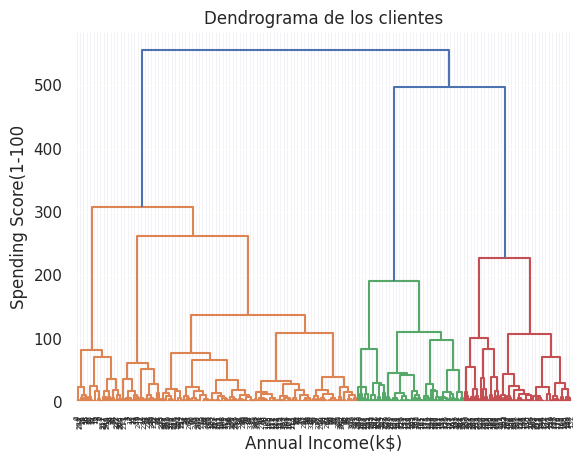

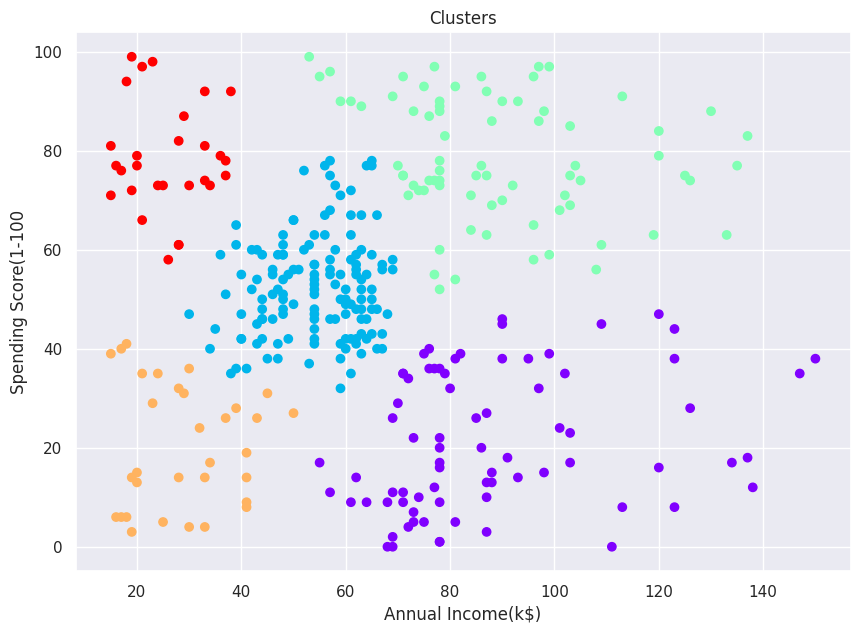

In [21]:
data_clustering = processed_data
dend = shc.dendrogram(shc.linkage(data_clustering, method="ward"))
cluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster.fit_predict(data_clustering)
plt.title("Dendrograma de los clientes")
plt.xlabel('Annual Income(k$)')
plt.ylabel('Spending Score(1-100')

plt.figure(figsize=(10, 7))
plt.title("Clusters")
plt.xlabel('Annual Income(k$)')
plt.ylabel('Spending Score(1-100')
plt.scatter(data_clustering[:,0], data_clustering[:,1], c=cluster.labels_, cmap='rainbow')